#Partie 1
#Nous choisissons le Sujet B pour créer un backtester pour Stratégies d’Investissement

In [7]:
!pip install yfinance
!pip install pandas

**Au début, nous avons introduit les bibliothèques dont nous avons besoin pour mieux traiter et appeler les données, mieux utiliser les fonctions et dessiner des images. Nos données financières proviennent de Yahoo Finance. ("math" fournit un ensemble de fonctions mathématiques et de constantes pour effectuer des opérations mathématiques courantes. Telles que des fonctions trigonométriques, des fonctions exponentielles, des fonctions logarithmiques, des constantes, etc. "from typing import Dict" Cette ligne de code est utilisée pour importer le type Dict . Ce type est utilisé pour représenter la structure clé d'un dictionnaire).**

**Nous avons créé une classe appelée Backtester pour effectuer des backtests de stratégie financière. __init__ est le constructeur (méthode d'initialisation) de la classe Backtester, qui accepte des paramètres entre parenthèses, tels que : une liste ou un tableau contenant des noms d'actifs, un dictionnaire contenant des données de cours de clôture d'actifs, un dictionnaire contenant des données de signaux de trading, etc. Dans la fonction, attribuez les paramètres transmis aux variables d'instance.**

**"load_data" est de charger les données d'actifs et de les stocker dans l'exemple de variable "self.data". Nous initialisons d’abord un dictionnaire vide pour stocker les données d’actifs chargées. Nous construisons ensuite le chemin d'accès au fichier de données d'actif et lisons les données, en nous assurant que le fichier et le chemin existent.**

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf
import os
from typing import Dict


class Backtester:

    def __init__(self, asset_names, asset_closes, signals, weights, risk_free_rate, market_returns,data_folder='Data'):
        self.data_folder = data_folder
        self.asset_names = asset_names
        self.asset_closes = asset_closes
        self.signals = signals
        self.weights = weights
        self.risk_free_rate = risk_free_rate
        self.market_returns = market_returns
        self.max_drawdown = 0.0
        self.max_seen_peak = 0
        self.load_data()

    def load_data(self):
        self.data = {}
        for asset_name in self.asset_names:
            file_path = os.path.join(self.data_folder, f'{asset_name}.csv')
            if os.path.exists(file_path):
                self.data[asset_name] = pd.read_csv(file_path, index_col=0, parse_dates=True)
            else:
                print(f'Data file for {asset_name} not found.')

In [22]:
    def strategy(self, dfs: Dict[str, pd.DataFrame]):
        signals = {}
        for asset_name, df in dfs.items():
             # Calculate customized moving average windows based on stock-specific characteristics
            volatility = df['Close'].std() 
            price_range = df['Close'].max() - df['Close'].min() 
            short_window = int(volatility * 0.5)  
            long_window = int(price_range * 0.1)  
            # Initialize signals DataFrame
            signals[asset_name] = pd.DataFrame(index=df.index)
            signals[asset_name]['Signal'] = 0.0
            # Calculate short-term and long-term moving averages            
            df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
            df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
             # Generate signals
            df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1.0, 0.0)
             # Shift the signal by one day to avoid lookahead bias
            signals[asset_name]['Signal'] = df['Signal'].shift(1)
        return signals
    
    def run_strategy(self, strategy_name: str, data: Dict[str, pd.DataFrame]):
        # Run the customized strategy for each asset
        signals = self.strategy(data)
        for asset_name, asset_data in data.items():
            # Get signals for the current asset
            asset_signals = signals[asset_name]
            print(f"Signals for {asset_name}:")
            print(asset_signals)
            
    def calculate_asset_daily_returns(self):
        asset_daily_returns = pd.DataFrame()
        for asset_name, asset_data in self.asset_closes.items():
            if asset_name in self.signals:
            # Calculate daily returns for the asset and multiply by signals
               asset_daily_returns[asset_name] = self.data[asset_name]['Close'].pct_change()*self.signals[asset_name]
            else:
               print(f'No signals found for {asset_name}.')
        return asset_daily_returns
    
    def calculate_asset_annualized_returns(self):
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = {}
        for asset_name, asset_daily_return in asset_daily_returns.items():
            total_days = len(asset_daily_return)
            if total_days > 0:
                asset_annualized_return = ((asset_daily_return + 1).prod()) ** (252 / total_days) - 1 
                asset_annualized_returns[asset_name] = asset_annualized_return
            else:
                print(f'No daily returns found for {asset_name}.')
        return asset_annualized_returns

    def calculate_asset_volatility(self, asset_daily_returns):
        asset_volatility = asset_daily_returns.std() * math.sqrt(252)
        return asset_volatility

    def calculate_portfolio_daily_returns(self, asset_daily_returns):
        pf_daily_returns = (asset_daily_returns * self.weights).sum(axis=1)
        return pf_daily_returns
    
    def calculate_portfolio_annualized_returns(self, asset_daily_returns):
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        total_days = len(pf_daily_returns)
        if total_days > 0:
            pf_annualized_return = ((pf_daily_returns + 1).prod()) ** (252 / total_days) - 1 
            return pf_annualized_return
        else:
            print(f'No daily returns found for pportfolio.')
            return None

    def calculate_portfolio_volatility(self, pf_daily_returns):
        pf_volatility = pf_daily_returns.std() * math.sqrt(252)
        return pf_volatility

    def calculate_annualized_sharpe_ratio(self, pf_daily_returns):
        avg_return = pf_daily_returns.mean()
        std_dev = pf_daily_returns.std()
        annualized_sharpe_ratio = (avg_return - self.risk_free_rate) / std_dev * math.sqrt(252)
        return annualized_sharpe_ratio

    def calculate_beta(self, pf_daily_returns):
        pf_daily_returns_aligned, market_returns_aligned = pf_daily_returns.align(self.market_returns, join='inner')
        cov_matrix = np.cov(pf_daily_returns_aligned, market_returns_aligned)
        portfolio_covariance = cov_matrix[0, 1]
        market_variance = np.var(market_returns_aligned)
        beta = portfolio_covariance / market_variance
        return beta

    def calculate_beta_up_down(self, daily_returns):
        daily_returns_aligned, market_returns_aligned = daily_returns.align(self.market_returns, join='inner')
        market_up_returns = market_returns_aligned[market_returns_aligned > 0]
        market_down_returns = market_returns_aligned[market_returns_aligned < 0]
        pf_up_returns = daily_returns_aligned[self.market_returns > 0]
        pf_down_returns = daily_returns_aligned[self.market_returns < 0]
        beta_up = self.calculate_beta(pf_up_returns)
        beta_down = self.calculate_beta(pf_down_returns)
        return beta_up, beta_down
        
    def start(self):
        self.max_drawdown = 0.0
        self.max_drawdown_duration = 0
        self.max_seen_peak = 0
        self.current_drawdown_duration = 0

    def calculate_max_drawdown(self, asset_name):
        price_series = self.asset_closes[asset_name]
        peak = price_series.iloc[0]
        max_drawdown = 0
        for price in price_series:
            if price > peak:
               peak = price
            drawdown = (peak - price) / peak
            if drawdown > max_drawdown:
               max_drawdown = drawdown
        self.max_drawdown = max_drawdown * 100

**"summary" est de calculer et de renvoyer des informations récapitulatives de la stratégie. Les résultats peuvent afficher le rendement quotidien, le rendement annualisé, la volatilité, le ratio de Sharpe, le coefficient bêta, le prélèvement maximum, etc. pour chaque actif et portefeuille. En bref, le résumé du dictionnaire contient des informations récapitulatives sur la stratégie, notamment les valeurs de divers indicateurs et des résumés de signaux.
"plot" est utilisé pour tracer les rendements des actifs et des portefeuilles, ainsi que la volatilité des portefeuilles. Introduisez ensuite les données, définissez le titre, la taille du graphique et la couleur de la courbe, puis ajoutez une légende.**

In [ ]:
    def summary(self):
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = self.calculate_asset_annualized_returns()
        asset_volatility = self.calculate_asset_volatility(asset_daily_returns)
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        pf_annualized_returns = self.calculate_asset_annualized_returns()
        pf_volatility = self.calculate_portfolio_volatility(pf_daily_returns)
        annualized_sharpe_ratio = self.calculate_annualized_sharpe_ratio(pf_daily_returns)
        beta = self.calculate_beta(pf_daily_returns)
        beta_up, beta_down = self.calculate_beta_up_down(pf_daily_returns)
        max_drawdown = self.max_drawdown

        signals_summary = {asset_name: self.signals[asset_name] for asset_name in self.asset_names}

        summary = {
            "asset_daily_returns": asset_daily_returns,
            "asset_annualized_returns": asset_annualized_returns,
            "asset_volatility": asset_volatility,
            "pf_daily_returns": pf_daily_returns,
            "pf_annualized_returns": pf_annualized_returns,
            "pf_volatility": pf_volatility,
            "annualized_sharpe_ratio": annualized_sharpe_ratio,
            "beta": beta,
            "beta_up": beta_up,
            "beta_down": beta_down,
        }
        return summary

    def plot(self):
        # Plot portfolio returns
        plt.figure(figsize=(10, 5))
        plt.subplot(2, 1, 1)
        asset_returns = self.calculate_asset_daily_returns()
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_returns)
        plt.plot(asset_returns.index, asset_returns, label=asset_names, alpha=0.7)
        plt.plot(pf_daily_returns.index, pf_daily_returns, label='Portfolio Returns', color='red')
        plt.title('Asset and Portfolio Returns')
        plt.legend()

        # Plot portfolio volatility
        plt.subplot(2, 1, 2)
        plt.plot(pf_daily_returns.index, pf_daily_returns.rolling(window=20).std() * math.sqrt(252),
                 label='Portfolio Volatility', color='green')
        plt.title('Portfolio Volatility (Rolling 20-Day Window)')
        plt.legend()

        plt.tight_layout()
        plt.show()

#Partie 2
#Utiliser des backtesteurs dans la stratégie

**Utilisez la classe Backtester pour effectuer des tests Backtester de stratégies de trading basées sur des données historiques. 
--- Utilisez 'AAPL', 'AMZN', 'GOOGL'. Téléchargez les données boursières pour une période de données personnalisée à partir de Yahoo Finance et enregistrez-les dans un fichier CSV. Créez un exemple de Backtester, exécutez une stratégie (basée sur un simple croisement de moyenne mobile) et obtenez des données de signal, calculez et imprimez des informations de backtest telles que les rendements, les rendements annualisés, la volatilité, le ratio de Sharpe, le bêta, etc. Tracez enfin les courbes de rendement des actifs et du portefeuille ainsi que la courbe de volatilité du portefeuille.**

Signals for AAPL:
            Signal
Date              
2022-01-03     NaN
2022-01-04     0.0
2022-01-05     0.0
2022-01-06     0.0
2022-01-07     0.0
...            ...
2023-12-22     0.0
2023-12-26     1.0
2023-12-27     1.0
2023-12-28     1.0
2023-12-29     1.0

[501 rows x 1 columns]
Signals for AMZN:
            Signal
Date              
2022-01-03     NaN
2022-01-04     0.0
2022-01-05     0.0
2022-01-06     0.0
2022-01-07     0.0
...            ...
2023-12-22     0.0
2023-12-26     0.0
2023-12-27     0.0
2023-12-28     0.0
2023-12-29     0.0

[501 rows x 1 columns]
Signals for GOOGL:
            Signal
Date              
2022-01-03     NaN
2022-01-04     0.0
2022-01-05     0.0
2022-01-06     0.0
2022-01-07     0.0
...            ...
2023-12-22     0.0
2023-12-26     0.0
2023-12-27     0.0
2023-12-28     0.0
2023-12-29     0.0

[501 rows x 1 columns]
Summary:
{'asset_daily_returns':                 AAPL      AMZN     GOOGL
2022-01-01       NaN       NaN       NaN
2022-01-02       

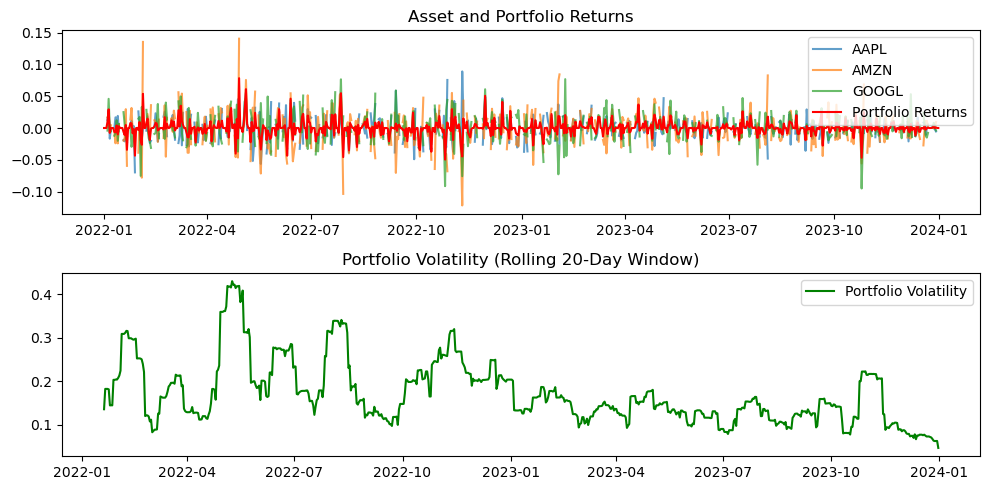

In [23]:
# Exampl usage
stock_symbols = ['AAPL', 'AMZN', 'GOOGL']
asset_names=stock_symbols
data_folder = 'Data'
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if not os.path.exists(file_path):
        print(f'Downloading {symbol} data...')
        data = yf.download(symbol, start='2022-01-01', end='2023-12-31')
        data.to_csv(file_path)
        print(f'Data saved to {file_path}')

# Create data
dates = pd.date_range(start='2022-01-01', end='2023-12-31')
num_assets = len(stock_symbols)
num_days = len(dates)

# Load your data into a dictionary
data = {}
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if os.path.exists(file_path):
        data[symbol] = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f'Data file for {symbol} not found.')

# Assume daily closing prices data for three assets
asset_closes = pd.DataFrame(np.random.randn(num_days, num_assets), index=dates, columns=stock_symbols)

# Assume weights data for three assets
weights = np.array([0.3, 0.4, 0.3])  # Sum of weights for three assets should be 1

# Assume risk-free rate as 0.02
risk_free_rate = 0.02

# Assume market returns data
market_returns = pd.Series(np.random.randn(num_days), index=dates)

# Create a Backtester instance
backtester = Backtester(asset_names, asset_closes,signals,weights, risk_free_rate, market_returns, data_folder='Data')
    
# Run the strategy 
backtester.run_strategy('strategy', data)

# Calculate and print summary information
summary = backtester.summary()
print("Summary:")
print(summary)

# Calculate and print maximum drawdown
for asset_name, asset_close in asset_closes.items():
    backtester.calculate_max_drawdown(asset_name)  # Pass asset_name instead of asset_close
    print(f"max_drawdown ({asset_name}): {backtester.max_drawdown}")

# Plot asset and portfolio daily returns as well as portfolio volatility
backtester.plot()

#Analyser les résultats

**AAPL et AMZN ont tous deux des rendements annualisés négatifs, ce qui indique qu'investir dans ces deux actions entraînera des pertes au cours de la période de backtest, AMZN perdant davantage.
GOOGL s'est relativement bien comporté et a obtenu un taux de rendement annualisé positif, ce qui indique qu'investir dans GOOGL a été rentable au cours de la période de backtest
Une volatilité élevée signifie des variations importantes du cours des actions et des risques plus élevés. Parmi les trois actions, AMZN présente la volatilité la plus élevée, ce qui indique que le cours de son action est le plus volatil et le plus risqué.
La volatilité de l'AAPL et de GOOGL est plus faible (par rapport à l'AMZN), mais elle reste autour de 30 %, et ce sont toujours des actifs très volatil.
---En regardant les données de rendement quotidien, GOOGL affiche des rendements positifs plus élevés certains jours, ce qui est cohérent avec son rendement annualisé positif.
Les rendements quotidiens de l'AAPL et de l'AMZN sont faibles, voire négatifs, la plupart du temps, conformément à leurs rendements annualisés
Le rendement quotidien du portefeuille reflète la performance moyenne de l'ensemble du portefeuille. Sa volatilité est de 18,56 %, ce qui est inférieur à celui d'un seul actif, ce qui montre que l'investissement de portefeuille peut diversifier les risques dans une certaine mesur**e...

**Le taux de rendement annualisé du portefeuille est similaire à celui de GOOGL. Cela peut être dû au fait que GOOGL obtient de meilleurs résultats dans le portefeuille et a un plus grand impact sur l'ensemble du portefeuille.
La volatilité du portefeuille (18,56 %) est inférieure à la volatilité de tous les actifs individuels, ce qui indique que la configuration du portefeuille contribue à réduire les risques d'investissement**

**annualized_sharpe_ratio=-27.16,ce ratio de Sharpe extrêmement bas indique que la performance du portefeuille est extrêmement mauvaise après prise en compte des facteurs de risque, et que les rendements sont loin d'être suffisants pour compenser les risques pris.**

**Bêta=0.00106,la valeur de bêta est proche de zéro, ce qui indique que ce portefeuille n'a presque aucune corrélation avec le marché et que les changements du marché ont très peu d'impact sur le portefeuille.**

**Bêta Up=
0.0020,la valeur de bêta up est légèrement supérieure au bêta, ce qui indique que le portefeuille a des réponses légèrement plus positives lorsque le marché monte.**

**Bêta Down=0.00041,la valeur de bêta down est très faible à la baisse, ce qui indique que le portefeuille réagit très faiblement lorsque le marché baisse et est très défensif.**

**Max Drawdown_AAPL=369,19 ; Max Drawdown_AMZN=196,26 ;Max Drawdown_GOOGL=268,70.La Max Drawdown f fait référence à la perte maximale qu'un portefeuille peut subir, et ces trois valeurs reflètent la pire performance de leurs actions respectives dans des conditions de marché défavorableLa Max Drawdown de .
AAPmum le plus élevé, ce qui indique qu'il présente les pertes potentielles les plus élevées et un risque plus élevé dans des conditions défavorablLa Max Drawdown de nt, AMZN et GOOGLmaux inférieurs, en particulier AMZN, qui présente un risque plus faible que A**PL.505.

#Conclusion

**Par conséquence,GOOGL a enregistré les performances les plus régulières, avec des rendements annualisés positifs et une volatilité modérée. Bien qu'AMZN ait une forte volatilité, son retrait maximum n'est pas le plus élevé et il peut y avoir une corrélation positive incomplète entre son risque et son retrait. Les rendements négatifs d'AAPL et le prélèvement maximum élevé indiquent qu'il s'agit d'un investissement à haut risque. L'allocation du portefeuille réduit considérablement la volatilité, mais le ratio de Sharpe est extrêmement faible, ce qui indique une mauvaise performance ajustée au risque.**